In [1]:
try:
    from undi import MuonNuclearInteraction
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('../../undi/')
    from undi import MuonNuclearInteraction
import matplotlib.pyplot as plt
import numpy as np

# Define lattice structure

The octahedral muon site in Cu is defined below.

In [3]:
angtom=1.0e-10 # m
a=3.6212625504 # Cu lattice constant, in Angstrom

Cu_Quadrupole_moment =  (-0.211) * (10**-28) # m^-2
atoms = [

    {'Position': np.array([0.5, 0.5, 0.5]) * a * angtom,
     'Label': 'mu'},

    {'Position': np.array([0.0    ,    0.5   ,     0.5])*angtom*a,
     'Label': 'Cu',
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment,
     'OmegaQmu': 3.2e6 # s^-1
    },

    {'Position': np.array([0.5    ,    0.0   ,     0.5])*angtom*a,
     'Label': 'Cu',
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment,
     'OmegaQmu': 3.2e6 # s^-1
    },

    {'Position': np.array([1.0    ,   0.5   ,     0.5])*angtom*a,
     'Label': 'Cu',
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment,
     'OmegaQmu': 3.2e6 # s^-1
    },

    {'Position': np.array([0.5    ,    1.0   ,     0.5])*angtom*a,
     'Label': 'Cu',
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment,
     'OmegaQmu': 3.2e6 # s^-1
    },

    {'Position': np.array([0.5    ,    0.5   ,     0.0])*angtom*a,
    'Label': 'Cu',
    'ElectricQuadrupoleMoment': Cu_Quadrupole_moment,
    'OmegaQmu': 3.2e6 # s^-1
    },

    {'Position': np.array([0.5    ,    0.5   ,     1.0])*angtom*a,
     'Label': 'Cu',
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment,
     'OmegaQmu': 3.2e6 # s^-1
    }
]

# Set Electric Field Gradient

There are two ways of treating quadrupole coupling with undi.
One can either specify 'OmegaQmu' and assume the electric field
gradient generated by the muon, or explicitly set it.
We opt for the latter option here. You may get the same result
removing the comment from the lines defining `OmegaQmu` above.

In [4]:
elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second

def Vzz_for_unit_charge_at_distance(r):
    epsilon0 = 8.8541878E-12 # ampere^2 ⋅ kilogram^−1 ⋅ meter^−3 ⋅ second^4
    elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second
    Vzz = (2./(4 * np.pi * epsilon0)) * (elementary_charge / (r**3))
    return Vzz

def Vzz_from_Celio_PRL():
    # q=0.27 angstrom^−3 is from PRL 39 836
    # (4 pi epsilon_0)^−1 (0.27 angstrom^−3) elementary_charge = 3.8879043E20 meter^−2 ⋅ volts
    Vzz = 1.02702 * 3.8879043E20 # the factor 1.02702 gives exactly 3.2e6 s^-1 for omega_q
    return Vzz

def gen_radial_EFG(p_mu, p_N, Vzz):
    x=p_N-p_mu
    n = np.linalg.norm(x)
    x /= n; r = 1. # keeping formula below for clarity
    return -Vzz * ( (3.*np.outer(x,x)-np.eye(3)*(r**2))/r**5 )


for idx, atom in enumerate(atoms):
    if atom['Label'] == 'Cu':
        atoms[idx]['EFGTensor'] = gen_radial_EFG(atoms[0]['Position'], atom['Position'], Vzz_from_Celio_PRL())
        
print(Vzz_from_Celio_PRL())

3.992955474186e+20


# Polarization function

The muon polarization is obtained with the method introduced by Celio.

In [5]:
steps = 200
tlist = np.linspace(0, 16e-6, steps)
signals = np.zeros([6,steps], dtype=np.float)


#LongitudinalFields = (0.0, 0.001, 0.003, 0.007, 0.008, 0.01)
LongitudinalFields = (0.0, 0.001)
for idx, Bmod in enumerate(LongitudinalFields):

    # Put field along muon polarization, that is always z
    B = Bmod * np.array([0,0.,1.])
    NS = MuonNuclearInteraction(atoms, external_field=B, log_level='info')

    # rotate the sumple such that the muon spin is aligned with
    # the 111 direction (and, just for convenience, the muon position is
    # set to (0,0,0) )
    NS.translate_rotate_sample_vec(np.array([0.,0.,1.]))

    print("Computing signal 4 times with LF {} T...".format(Bmod), end='', flush=True)
    signal_Cu = NS.celio(tlist,  k=2)
    for i in range(3):
        print('{}...'.format(i+1), end='', flush=True)
        signal_Cu += NS.celio(tlist, k=2)
    print('done!')
    signal_Cu /= float(i+1+1)
    del NS

    signals[idx]=signal_Cu

INFO:undi:Hilbert space is 8192 dimensional


Computing signal 4 times with LF 0.0 T...(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
1...(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
2...(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
3...(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.9859

done!


INFO:undi:Hilbert space is 8192 dimensional


Computing signal 4 times with LF 0.001 T...(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
1...(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
2...(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
3...(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.985910948372e+20, 0.0)
(-2133339.577873068, 7.98

...and the results is:

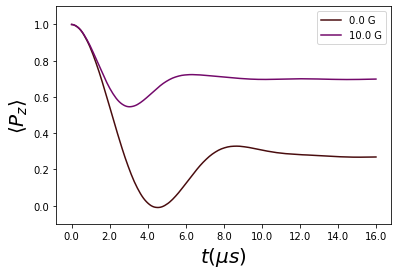

In [6]:
fig, axes = plt.subplots(1,1)
for i, Bmod in enumerate(LongitudinalFields):
    color = list(np.random.choice(range(256), size=3)/256)
    axes.plot(tlist, signals[i], label='{} G'.format(Bmod*1e4), linestyle='-', color=color)
axes.set_ylim((-0.1,1.1))
ticks = np.round(axes.get_xticks()*10.**6)
axes.set_xticklabels(ticks)
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'$\left<P_z\right>$', fontsize=20);
plt.legend()
plt.show()

# Exact solution

This takes a long time and requires quite a lot of memory!
Results have been stored for comparison.
Set `RUN_EXACT_SOLUTION` to True to recompute it.

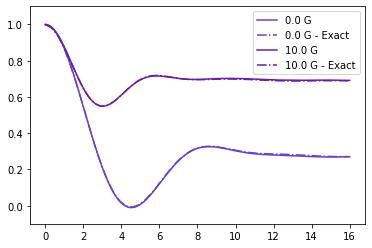

In [6]:
RUN_EXACT_SOLUTION = False
steps = 50
exact_tlist = np.linspace(0, 16e-6, steps)
#exact_signals = np.zeros([6,steps], dtype=np.float)
# Time Interval between 0 and 16 us, 50 steps, LongitudinalFields = (0.0, 0.001, 0.003, 0.007, 0.008, 0.01)
exact_signals = np.array([[ 1.        ,  0.98282653,  0.93964818,  0.8727281 ,  0.78028361,
         0.67469059,  0.56109296,  0.44254458,  0.33016254,  0.22835089,
         0.14071887,  0.07266857,  0.02508912, -0.00138344, -0.00777295,
         0.00332417,  0.02902002,  0.06492124,  0.10737172,  0.15200355,
         0.19525238,  0.23504429,  0.26796097,  0.29364225,  0.31249597,
         0.32294924,  0.32736432,  0.32758011,  0.32305998,  0.3168234 ,
         0.31049457,  0.30331904,  0.29736902,  0.29326092,  0.28955219,
         0.28722038,  0.28623668,  0.28491011,  0.28388694,  0.28322455,
         0.28156636,  0.27978173,  0.27826943,  0.27607753,  0.27416934,
         0.27298859,  0.27164413,  0.27081398,  0.27069118,  0.27024463],
       [ 1.        ,  0.98293689,  0.94103195,  0.87974072,  0.80302765,
         0.72482631,  0.65413908,  0.59895465,  0.56280528,  0.54742553,
         0.55334184,  0.57318891,  0.60218095,  0.63512508,  0.66574397,
         0.69081457,  0.70740053,  0.71651987,  0.71913932,  0.71600087,
         0.71090861,  0.70542094,  0.70019074,  0.69693086,  0.6955793 ,
         0.69528207,  0.69608999,  0.69741402,  0.69823249,  0.69877767,
         0.69893606,  0.69820817,  0.69717636,  0.69597567,  0.69432885,
         0.69276073,  0.69138666,  0.68998791,  0.68896328,  0.68837029,
         0.68798691,  0.68802579,  0.68841152,  0.68882866,  0.68930834,
         0.68973257,  0.68982279,  0.68966208,  0.68929406,  0.68864183],
       [ 1.        ,  0.98379849,  0.95110385,  0.92430074,  0.92333194,
         0.94322695,  0.96888701,  0.98229823,  0.97805614,  0.96199376,
         0.94602602,  0.94102634,  0.94716167,  0.95813592,  0.96467449,
         0.96437462,  0.95925356,  0.95489471,  0.95351849,  0.95495805,
         0.95698291,  0.95811534,  0.95793408,  0.95721899,  0.95668732,
         0.9566025 ,  0.95680559,  0.95701551,  0.95707425,  0.95701427,
         0.9569539 ,  0.95694134,  0.9569614 ,  0.95701089,  0.95704409,
         0.95702411,  0.95701233,  0.9570149 ,  0.95701059,  0.9570523 ,
         0.95710172,  0.95710734,  0.95712119,  0.95711323,  0.95706506,
         0.95704849,  0.95704016,  0.95703239,  0.95707086,  0.95711522],
       [ 1.        ,  0.9875797 ,  0.98140832,  0.98621011,  0.97075648,
         0.95669399,  0.95541905,  0.94319278,  0.92842263,  0.92389329,
         0.91594141,  0.90336002,  0.89654501,  0.89062457,  0.88065119,
         0.87288486,  0.86795318,  0.86108697,  0.85435035,  0.85031619,
         0.84608276,  0.84103892,  0.83743184,  0.83435711,  0.83042769,
         0.82696249,  0.82416836,  0.82088203,  0.81775033,  0.81520849,
         0.81250997,  0.80989694,  0.80777116,  0.80572486,  0.80367457,
         0.80205509,  0.80067282,  0.79915915,  0.7980214 ,  0.79720875,
         0.79614609,  0.79538015,  0.79497777,  0.7942634 ,  0.79376039,
         0.79363704,  0.79320925,  0.79291028,  0.79302161,  0.79286575],
       [ 1.        ,  0.98879191,  0.98699508,  0.98589855,  0.96748469,
         0.96150537,  0.94988836,  0.93042286,  0.92044974,  0.90441159,
         0.88659453,  0.8748919 ,  0.85867707,  0.84326163,  0.8318069 ,
         0.81687864,  0.80418869,  0.79334047,  0.78042514,  0.77008204,
         0.7599696 ,  0.74953374,  0.74097611,  0.73229548,  0.72431931,
         0.71752935,  0.71086347,  0.70512305,  0.70026205,  0.69563065,
         0.69186035,  0.68876905,  0.68581902,  0.68370366,  0.6819059 ,
         0.68029858,  0.67945545,  0.67848443,  0.67807933,  0.67807028,
         0.67782256,  0.67848698,  0.67905924,  0.67970109,  0.68120834,
         0.68242028,  0.68400175,  0.6861668 ,  0.68811348,  0.69043407],
       [ 1.        ,  0.99130363,  0.99367316,  0.98441018,  0.98244009,
         0.97815888,  0.97460671,  0.9757831 ,  0.97160007,  0.9734014 ,
         0.96809696,  0.96718836,  0.9624622 ,  0.95981762,  0.95816497,
         0.95578323,  0.95672477,  0.95537404,  0.95691268,  0.95596032,
         0.95648078,  0.95585914,  0.95559188,  0.95527909,  0.95483432,
         0.95475075,  0.9544889 ,  0.95444332,  0.9543944 ,  0.95427475,
         0.95433552,  0.954215  ,  0.95419628,  0.95416875,  0.95403384,
         0.95404225,  0.9539122 ,  0.9538729 ,  0.95384906,  0.95378848,
         0.95385451,  0.95386919,  0.95395887,  0.95410335,  0.95416793,
         0.95437978,  0.95446006,  0.9546102 ,  0.95474143,  0.9547932 ]]);


if RUN_EXACT_SOLUTION:
    LongitudinalFields = (0.0, 0.001, 0.003, 0.007, 0.008, 0.01)
    for idx, Bmod in enumerate(LongitudinalFields):

        # Put field along muon polarization, that is always z
        B = Bmod * np.array([0,0.,1.])
        NS = MuonNuclearInteraction(atoms, external_field=B, log_level='info')

        # rotate the sumple such that the muon spin is aligned with
        # the 111 direction (and, just for convenience, the muon position is
        # set to (0,0,0) )
        NS.translate_rotate_sample_vec(np.array([1.,1.,1.]))

        print("Computing exact signal for B={}".format(Bmod))
        exact_signals[idx]=NS.polarization(tlist, cutoff=2.0e-10)
        del NS

fig, axes = plt.subplots(1,1)
for i, Bmod in enumerate(LongitudinalFields):
    color = list(np.random.choice(range(256), size=3)/256)
    axes.plot(1e6*tlist, signals[i], label='{} G'.format(Bmod*1e4), linestyle='-', color=color)
    axes.plot(1e6*exact_tlist, exact_signals[i], label='{} G - Exact'.format(Bmod*1e4), linestyle='-.', color=color)
axes.set_ylim((-0.1,1.1))
plt.legend()
plt.show()